In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Metric box classifier: evaluation metrics

**25.08.2020**

It's important to have a measure of how well a classifier performs, and given the data, there are a few metrics which can be used to measure this.

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [4]:
from synthetic_data.plotting import plot_trajectory, add_plot_trajectory, add_plot_seg_boxes, add_plot_cluster_boxplots

In [5]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays

# Theory

## Standard metrics

There are a few standard metrics which can be used for classification problems. Here, we use the precision and recall as well as the error (aka the accuracy).

For all metrics, there are a few things to consider.
1. The sequence of events is not simply classified as independent events; the clusters of events also matter
2. Since the clusters matter, the correct number of segments also matters
3. However, there is (or may be) a propensity towards false positive stays but which (may) have a small impact.

Therefore, we apply the metrics to the entire sequence and also on the segments of the sequence.

### Precision and Recall
 
A brief review of the definitions:

Let the total number of stay (travel) events be $N_s$ ($N_t$) and the corresponding incorrect counts denoted as $\tilde{N}_{\{\}}$. 
* $\mathrm{prec.} = {N_s}/(N_s + \tilde{N}_s)$, the number of correctly classified stay-events over the total number classified stay events.
    * this is sensitive the the number of false positives
* $\mathrm{rec.} = {N_s}/(N_s + \tilde{N}_t)$, the number of correctly classified stay-events over the total number stay events.

### Error fraction (and/or Accuracy)

The error is given effectively by treating the arrays of labels as vectors of 1's (stays) and 0's (travels) and then computing 

$\varepsilon = |\mathbf{v}_{\mathrm{true}} - \mathbf{v}_{\mathrm{pred}}|/\mathrm{size}(\mathbf{v}_{\mathrm{true}})$. 

This is related to the accuracy by 

$\mathrm{acc.} = 1 - \varepsilon$, 

which is the same as 

$\mathrm{acc.} = \big((N_t + \tilde{N}_s + \tilde{N}_t + N_s) - (\tilde{N}_s + \tilde{N}_t)\big)/(N_t + \tilde{N}_s + \tilde{N}_t + N_s)$

---

# Illustrations

Here is a bit more theory but fleshed out with some examples

## Example 1

In [6]:
from synthetic_data.trajectory_class import get_pickle_trajectory
from stay_classification.metric_box_classifier.metric_box_classifier import stay_classifier_testing

time_thresh = 1/6
dist_thresh=0.25

In [7]:
data_dir = f"../../testdata/testdata_training_set__canonical_3stays/"
stays_tag = 3

### Classification

Load data

In [8]:
trajectory_nr = 445 #488 #958 #445

trajectory_tag = f"trajectory{trajectory_nr}_{stays_tag}stays"    
path_to_file =  data_dir + trajectory_tag

In [9]:
t_arr, r_arr, x_arr, segments = get_pickle_trajectory(path_to_file)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

Classification

In [10]:
# Get the stay clusters
all_clusters = stay_classifier_testing(t_arr, x_arr, dist_thresh, time_thresh, False)    

Plotting

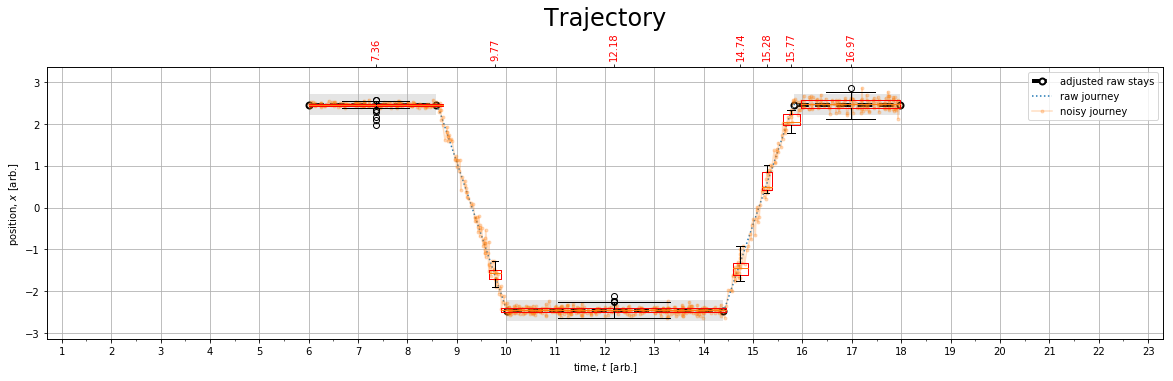

In [11]:
fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);
#ax.set_title(f"{stage_titels[-1]}", fontsize=16);

**Notes**
* There are three stays, all of which are mostly correctly identified by the classifier
* There are a few false stays (_ie_ false positives) during the main travels but these are all mostly short in duration

#### Prec & Rec

#### Total Precision and Recall

The first is to consider the entire sequence of points which are classified as either "stay" (1) or "travel" (0).
    
Again, the definitions of the (p)rec. scores:
* $\mathrm{prec.} = {N_s}/(N_s + \tilde{N}_s)$
* $\mathrm{rec.} = {N_s}/(N_s + \tilde{N}_t)$
    * **Note** if all events are classified as a stay, then $\tilde{N}_t = 0$, and recall is unity.

In [12]:
from stay_classification.metrics import eval_synth_data, eval_synth_data_clusters_long, get_segments_scores, print_p_and_r

In [13]:
prec, rec, cmat = eval_synth_data(t_arr, segments, all_clusters[-1])
print_p_and_r(all_clusters[-1], prec, rec, cmat)

    7 clusters, lengths:, [184, 19, 328, 28, 17, 18, 131]
	prec.: 0.861
	 rec.: 1.000
[[ 87 102]
 [  0 633]]


The confusion matrix is also given, but as usual, it is confusing

$\left[\begin{array}[cc]\\ N_t & \tilde{N}_s\\ \tilde{N}_t & N_s \end{array}\right] = \left[\begin{array}[cc]\\ 87 & 102\\ 0 & 633 \end{array}\right]$

Let's break it down:
* $N_t $ is the number of correctly identified travel events
    * there are overall 189 true travel events but the classifier only gets 87 of those correct
* $\tilde{N}_s$ is the number of false stay events (mis-labeled travel events)
    * there are 102 of these
* $\tilde{N}_t$ is the number of false travel events (mis-labeled stay events)
    * here, the classifier gets 0, which is common given the spatial constraints of the synthetic data and the spatial resolution of the classifier
* $N_s$ is the number of correctly identified stay events
    * for this example, all the true stay events are identified by the classifier.

#### Segment-based Precision and Recall

The total (p)rec. scores above are not specific enough since there no indication if the total number of stays is correct or not.
* As an example, consider two adjacent predicted stays which match with a true stay; 
    using only the labels misses the fact that there are two predicted stays when there should only be one.

A way to measure this is to generalize these score to the predicted segments, _ie_ to the stays and travels. 

Let the number of stay (travel) events in segment $i$ be $n_{s,i}$($n_{t,i}$) and $\tilde{n}_{\{\}}$ (as above). 
The the scores are given as 
* $\mathrm{prec.}_i = n_{s,i}/(n_{s,i} + \tilde{n}_{s,i})$
* $\mathrm{rec.}_i = n_{s,i}/(n_{s,i} + \tilde{n}_{t,i})$

To get an overall measure, the segment scores are weighted by the duration and then summed over. 
For each segment $s_i$,
1. check it against the true stays to see if there are any overlaps, and compute the scores
    1. if so, compute (p)rec.s for all overlapping sections
        * when a pred. segment overlaps multiple true segments, the average of the scores is used
        * Since the pred./true stay segments can be any size, they are first embedded into the entire sequence (see the methods below).
    2. if not, then assign (p)rec.s as $0$ for the segment
2. compute the total duration of the segment and multiply the segment score by a weight
    * Normalize by the total sum of pred. durations. 
    * this helps minimize the false positives which are short
3. compute the average, and/or the weighted average, over all pred. stays    

In [14]:
get_segments_scores(t_arr, segments, all_clusters[-1], True);

Predicted 7 of 3 true clusters

Cluster   0: [   0, 183]; dur:  2.713, (frac.  0.261)
             [   0, 175], overlap
             [ 272, 591], none
             [ 685, 821], none

	overlaps with 1 true cluster(s):
          0: [   0, 175]; prec.:  0.957; rec.:  1.000

Cluster   1: [ 244, 264]; dur:  0.230, (frac.  0.022)
             [   0, 175], none
             [ 272, 591], none
             [ 685, 821], none

	No overlap
	                    prec.:  0.000; rec.:  0.000

Cluster   2: [ 266, 593]; dur:  4.554, (frac.  0.439)
             [   0, 175], none
             [ 272, 591], overlap
             [ 685, 821], none

	overlaps with 1 true cluster(s):
          1: [ 272, 591]; prec.:  0.976; rec.:  1.000

Cluster   3: [ 597, 624]; dur:  0.321, (frac.  0.031)
             [   0, 175], none
             [ 272, 591], none
             [ 685, 821], none

	No overlap
	                    prec.:  0.000; rec.:  0.000

Cluster   4: [ 636, 654]; dur:  0.208, (frac.  0.020)
             [

**Notes** 
* The three main stays are found by the classifier, each with $\mathrm{(p)rec} > 0.95$
* The avg. scores are relatively low because there are three false stays and one misalinged stay
    * however, these are relatively short in duration
* The weighted avg. (as "`w-avg.`"), shows a more useful measure of how good the classification is. 
    * _ie_ it's not as bad as $\mathrm{(p)rec} \approx 0.44$

### Error

#### Total error

In [16]:
from stay_classification.metrics import get_pred_labels, get_labels_from_clusters

In [17]:
from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays

In [18]:
true_indices = get_stay_indices(get_adjusted_stays(segments, t_arr), t_arr)
true_labels = np.zeros(t_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

pred_labels = get_pred_labels(all_clusters[-1], t_arr.shape)

In [19]:
err__labels = abs(true_labels-pred_labels)
err__labels[err__labels == 0] = np.nan

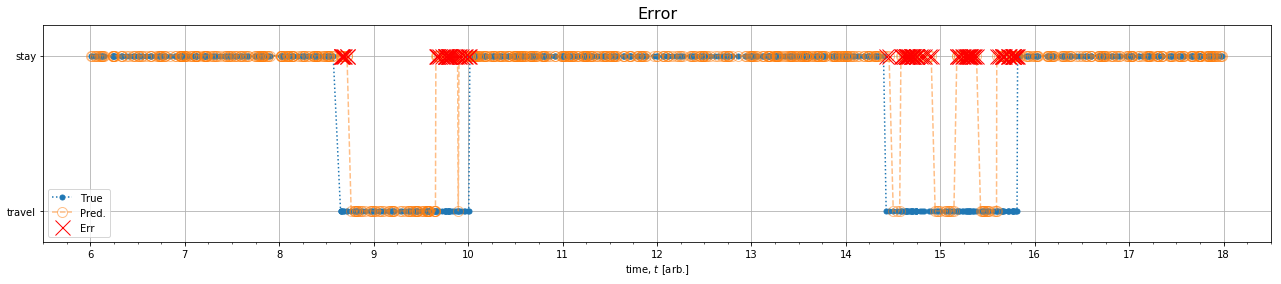

In [20]:
fig, ax = plt.subplots(1,1,figsize=(22,4))

plt.plot(t_arr, true_labels, '.:', markersize=10, label='True')
plt.plot(t_arr, pred_labels, 'o--', markerfacecolor="None", markersize=10, label='Pred.', alpha=0.5)
plt.plot(t_arr, err__labels, 'rx', markersize=15, label='Err')
plt.ylim(-0.2,1.2)
plt.xlim(5.5,18.5)

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

plt.xlabel(r'time, $t$ [arb.]')

ax.set_yticks([0,1])
ax.set_yticklabels(['travel', 'stay'])
ax.set_title('Error', fontsize=16)

plt.legend()
plt.grid();

In [21]:
get_err = lambda trues, preds: np.sum(abs(trues-preds))/trues.size

In [22]:
for clusters in all_clusters:
    
    pred_labels = get_pred_labels(clusters, t_arr.shape)
    
    print(f"Error: {get_err(true_labels,pred_labels):5.3} (Acc.: {(1-get_err(true_labels,pred_labels)):5.3})")

Error:  0.22 (Acc.:  0.78)
Error: 0.201 (Acc.: 0.799)
Error: 0.201 (Acc.: 0.799)
Error: 0.201 (Acc.: 0.799)
Error: 0.124 (Acc.: 0.876)


#### Segment-based error

The total error (also accuracy) can be divided among the segments in the same way as the (p)rec. scores above. 

Again, tet the number of stay (travel) events in segment $i$ be $n_{s,i}$($n_{t,i}$) and $\tilde{n}_{\{\}}$ (as above). 
Then, the segment error is  
* $\varepsilon_i \propto \tilde{n}_{t,i} + \tilde{n}_{s,i}$

As above, the segment errors are simply averaged and/or weighted by the duration and then summed over. 
When the latter is used, then for each segment $s_i$,
1. check it against the true stays to see if there are any overlaps, and compute the segment error
    1. if so, compute (p)rec.s for all overlapping sections
        * Since the pred./true stay segments can be any size, they are first embedded into the entire sequence.
        * when a pred. segment overlaps multiple true segments, 
            * the average of the error is used since the true segment is counted multiple times        
    2. if not, then compute the error of the pred. stay against nothing
2. Use the duration-weighting as above
3. compute the average, and/or the weighted average, over all pred. stays
    
**Note** when a true stay is not shared among pred. stays, then $N_{\mathrm{pred.\,stays}} \cdot \mathrm{avg.} = \mathrm{tot. avg.}$

In [24]:
from stay_classification.metrics import get_segments_errs

In [25]:
get_segments_errs(t_arr, segments, all_clusters[-1], True);

Predicted 7 of 3 true clusters

Cluster   0: [   0, 183]; dur:  2.713, (frac.  0.261)
             [   0, 175], overlap
             [ 272, 591], none
             [ 685, 821], none

	Overlap with 1 true cluster(s):
          0; [   0, 175]; err.:  0.010; w-avg. err.:  0.003

Cluster   1: [ 244, 264]; dur:  0.230, (frac.  0.022)
             [   0, 175], none
             [ 272, 591], none
             [ 685, 821], none

	No overlap
                          err.:  0.026; w-avg. err.:  0.001

Cluster   2: [ 266, 593]; dur:  4.554, (frac.  0.439)
             [   0, 175], none
             [ 272, 591], overlap
             [ 685, 821], none

	Overlap with 1 true cluster(s):
          1; [ 272, 591]; err.:  0.010; w-avg. err.:  0.004

Cluster   3: [ 597, 624]; dur:  0.321, (frac.  0.031)
             [   0, 175], none
             [ 272, 591], none
             [ 685, 821], none

	No overlap
                          err.:  0.034; w-avg. err.:  0.001

Cluster   4: [ 636, 654]; dur:  0.20

**Notes** 
* The three main stays are found by the classifier, each with $\varepsilon_i \approx 0.01$
* The three false stays have $\varepsilon_i \approx 0.02-0.03$ and one misalinged stay has $\varepsilon_i \approx 0.18$
    * the outlier is large since the pred. stay is a small part of a larger true stay.
* The avg. scores are relatively high due to the misaligned outlier
    * however, these are less than the total error due to the averaging, and
    * despite the outlier avg being larger than the total
        * the outlier double-counts the last true stay's events in the averages 
* The weighted avg. is a bit less than the avg., as expected
    * the weighting brings down the outlier's error

### Check the last set of clusters

In [26]:
from stay_classification.metric_box_classifier.metric_box_classifier_gaps import get_clust_metrics, get_gap_metrics

In [27]:
def print_cluster_metrics(clusters):
    
    print(f"  IQR-len,    dur,  dmedi,   dmea,   mean, median")
    for n in range(len(clusters)):
        if n == 0:
            printstr = get_clust_metrics(clusters[n], t_arr, x_arr, time_thresh)
            print(f"{n:4d} {printstr}")
        else:
            printstr = get_gap_metrics(clusters[n-1],clusters[n], t_arr, x_arr, time_thresh)
            print(f"     {printstr}")
            printstr = get_clust_metrics(clusters[n], t_arr, x_arr, time_thresh)
            print(f"{n:4d} {printstr}")
    
    return None

In [28]:
print_cluster_metrics(all_clusters[-1])

  IQR-len,    dur,  dmedi,   dmea,   mean, median
   0  184,  2.713,   ----,   ----,  2.450,  2.453
       62,  0.941,  4.028,  4.036,  0.186,  0.055  
   1   19,  0.230,   ----,   ----, -1.586, -1.575
        3,  0.015,  0.878,  0.869, -2.129, -2.095  WARNING: too short
   2  328,  4.554,   ----,   ----, -2.454, -2.452
        5,  0.126,  1.016,  1.043, -1.982, -1.975  WARNING: too short
   3   28,  0.321,   ----,   ----, -1.412, -1.437
       13,  0.272,  1.938,  2.046, -0.316, -0.285  
   4   17,  0.208,   ----,   ----,  0.634,  0.501
       14,  0.215,  1.533,  1.440,  1.386,  1.356  
   5   18,  0.342,   ----,   ----,  2.074,  2.034
        2,  0.030,  0.437,  0.400,  2.436,  2.436  WARNING: too short
   6  131,  2.008,   ----,   ----,  2.474,  2.471


---

## Example 2

Here is a different example to highlight some issues.

In [29]:
trajectory_nr = 488 #958 #445


trajectory_tag = f"trajectory{trajectory_nr}_{stays_tag}stays"    
path_to_file =  data_dir + trajectory_tag

t_arr, r_arr, x_arr, segments = get_pickle_trajectory(path_to_file)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

# Get the stay clusters
all_clusters = stay_classifier_testing(t_arr, x_arr, dist_thresh, time_thresh, False)    

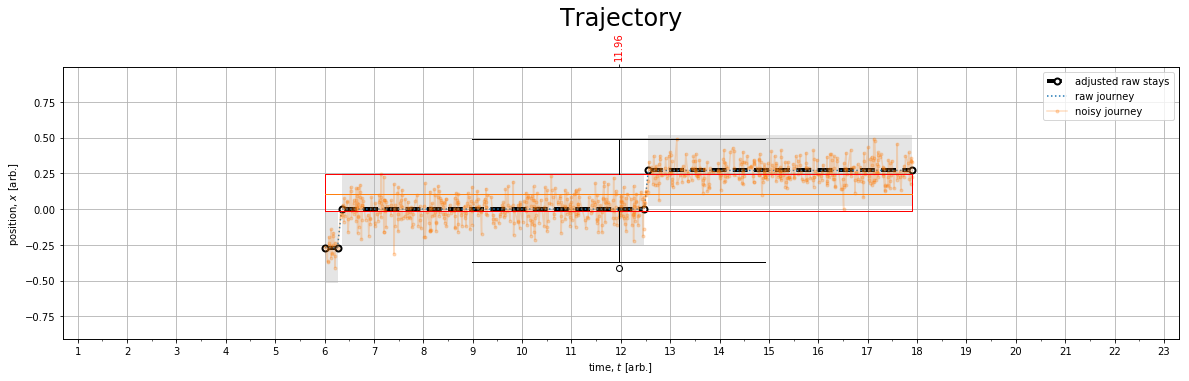

In [30]:
fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);
#ax.set_title(f"{stage_titels[-1]}", fontsize=16);

### Resolutions
The aboveclassifier sees only one cluster, and correctly since the true stays are within the given resolution. 

If the distance threshold is reduced, then different classifications are found.

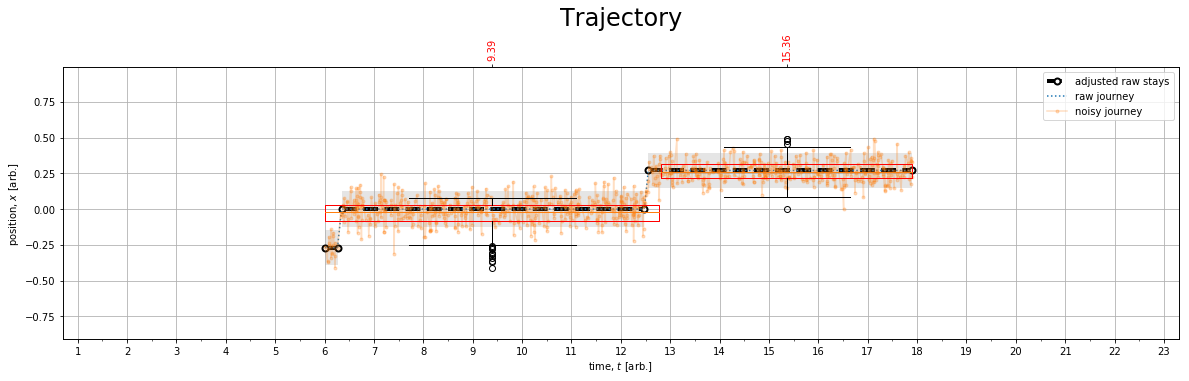

In [31]:
res_factor = 2
# Get the stay clusters
all_clusters_res2 = stay_classifier_testing(t_arr, x_arr, dist_thresh/res_factor, time_thresh, False)   
fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh/res_factor, ax)
ax.set_xlim(0.7,23.3)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh/res_factor, ax)
add_plot_cluster_boxplots(t_arr, x_arr, all_clusters_res2[-1], dist_thresh/res_factor, ax)
ax.set_ylim(ylim);
#ax.set_title(f"{stage_titels[-1]}", fontsize=16);

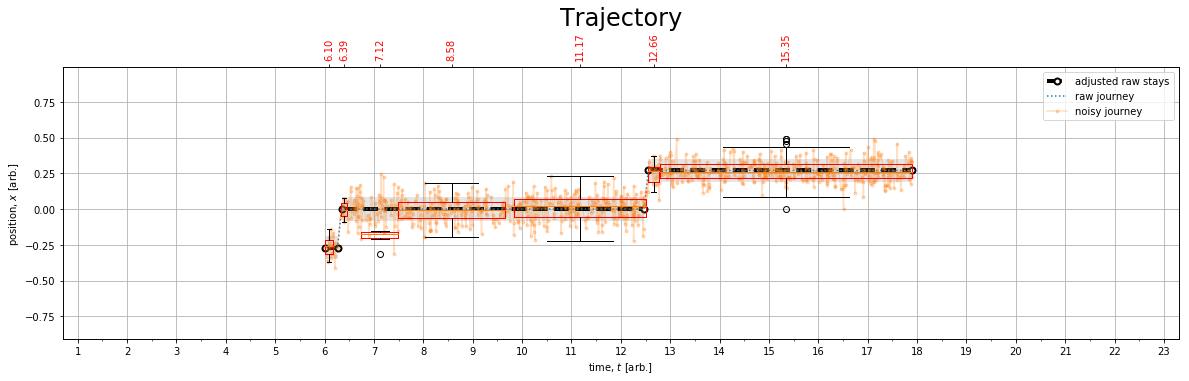

In [32]:
res_factor = 3
# Get the stay clusters
all_clusters_res3 = stay_classifier_testing(t_arr, x_arr, dist_thresh/res_factor, time_thresh, False)   
fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh/res_factor, ax)
ax.set_xlim(0.7,23.3)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh/res_factor, ax)
add_plot_cluster_boxplots(t_arr, x_arr, all_clusters_res3[-1], dist_thresh/res_factor, ax)
ax.set_ylim(ylim);
#ax.set_title(f"{stage_titels[-1]}", fontsize=16);

### Total prec & rec

In [33]:
prec, rec, cmat = eval_synth_data(t_arr, segments, all_clusters[-1])

In [34]:
print_p_and_r(all_clusters[-1], prec, rec, cmat)

    1 clusters, lengths:, [860]
	prec.: 0.992
	 rec.: 1.000
[[  0   7]
 [  0 853]]


In [35]:
print_p_and_r(all_clusters_res2[-1], *eval_synth_data(t_arr, segments, all_clusters_res2[-1]))

    2 clusters, lengths:, [392, 360]
	prec.: 0.992
	 rec.: 0.996
[[  0   7]
 [  3 850]]


In [36]:
print_p_and_r(all_clusters_res3[-1], *eval_synth_data(t_arr, segments, all_clusters_res3[-1]))

    7 clusters, lengths:, [15, 10, 6, 150, 210, 18, 363]
	prec.: 0.991
	 rec.: 0.948
[[  0   7]
 [ 44 809]]


**Notes**
* the different spatial resolutions show a slight decrease in both the (p)rec. scores, but these are mostly high.

### Segment-based scores

Changing the resolution in this example shows the prec.-rec. trade-off, which is evident in the segment-based scoring.

In [37]:
get_segments_scores(t_arr, segments, all_clusters[-1], True);

Predicted 1 of 3 true clusters

Cluster   0: [   0, 859]; dur: 11.891, (frac.  1.000)
             [   0,  18], overlap
             [  21, 473], overlap
             [ 479, 859], overlap

	overlaps with 3 true cluster(s):
          0: [   0,  18]; prec.:  0.022; rec.:  1.000
          1: [  21, 473]; prec.:  0.527; rec.:  1.000
          2: [ 479, 859]; prec.:  0.443; rec.:  1.000

Stats: 
    min. prec.:  0.331;    min. rec.:  1.000
    avg. prec.:  0.331;    avg. rec.:  1.000
  w-avg. prec.:  0.331;  w-avg. rec.:  1.000
    tot. prec.:  0.992;    tot. rec.:  1.000

Durations: 
tot. trajectory duration: 11.891 
tot. true stays duration: 11.717 (0.985) 
tot. pred stays duration: 11.891 (1.000)


In [38]:
get_segments_scores(t_arr, segments, all_clusters_res2[-1], True);

Predicted 2 of 3 true clusters

Cluster   0: [   0, 496]; dur:  6.766, (frac.  0.571)
             [   0,  18], overlap
             [  21, 473], overlap
             [ 479, 859], overlap

	overlaps with 3 true cluster(s):
          0: [   0,  18]; prec.:  0.038; rec.:  1.000
          1: [  21, 473]; prec.:  0.911; rec.:  1.000
          2: [ 479, 859]; prec.:  0.036; rec.:  0.047

Cluster   1: [ 500, 859]; dur:  5.086, (frac.  0.429)
             [   0,  18], none
             [  21, 473], none
             [ 479, 859], overlap

	overlaps with 1 true cluster(s):
          2: [ 479, 859]; prec.:  1.000; rec.:  0.945

Stats: 
    min. prec.:  0.329;    min. rec.:  0.682
    avg. prec.:  0.664;    avg. rec.:  0.814
  w-avg. prec.:  0.617;  w-avg. rec.:  0.795
    tot. prec.:  0.992;    tot. rec.:  0.996

Durations: 
tot. trajectory duration: 11.891 
tot. true stays duration: 11.717 (0.985) 
tot. pred stays duration: 11.852 (0.997)


In [39]:
get_segments_scores(t_arr, segments, all_clusters_res3[-1], True);

Predicted 7 of 3 true clusters

Cluster   0: [   0,  14]; dur:  0.169, (frac.  0.015)
             [   0,  18], overlap
             [  21, 473], none
             [ 479, 859], none

	overlaps with 1 true cluster(s):
          0: [   0,  18]; prec.:  1.000; rec.:  0.789

Cluster   1: [  19,  28]; dur:  0.135, (frac.  0.012)
             [   0,  18], none
             [  21, 473], overlap
             [ 479, 859], none

	overlaps with 1 true cluster(s):
          1: [  21, 473]; prec.:  0.800; rec.:  0.018

Cluster   2: [  59, 108]; dur:  0.746, (frac.  0.066)
             [   0,  18], none
             [  21, 473], overlap
             [ 479, 859], none

	overlaps with 1 true cluster(s):
          1: [  21, 473]; prec.:  1.000; rec.:  0.110

Cluster   3: [ 110, 259]; dur:  2.160, (frac.  0.192)
             [   0,  18], none
             [  21, 473], overlap
             [ 479, 859], none

	overlaps with 1 true cluster(s):
          1: [  21, 473]; prec.:  1.000; rec.:  0.331

Cluster 

**Notes**

The original had quite a low prec., but a perfect rec (_ie_ it labeled all events as stay-events),
```
  avg. prec.:  0.331;    avg. rec.:  1.000
w-avg. prec.:  0.331;  w-avg. rec.:  1.000
  tot. prec.:  0.992;    tot. rec.:  1.000
```

These score were mostly affected by the resolution increases. 
The $2\times$ increase (halving the spatial threshold) increased the prec., 
but also decreased the rec., since the first pred. cluster overlaps with
all other clusters, two very minimally with low scores. 
```
  avg. prec.:  0.664;    avg. rec.:  0.814
w-avg. prec.:  0.617;  w-avg. rec.:  0.795
  tot. prec.:  0.992;    tot. rec.:  0.996    

``` 
The scenario goes further as the resolution is increased. 
More, smaller clusters are found (one is misplaced in $x$). 
Now, there are fewer pred. stays, but all event labeled as stay events, 
are indeed true stays _events_, which means less false positives, but
also less true positives. 
```
  avg. prec.:  0.961;    avg. rec.:  0.386
w-avg. prec.:  0.992;  w-avg. rec.:  0.626
  tot. prec.:  0.991;    tot. rec.:  0.948
```  

### Error

#### Total error

In [40]:
true_indices = get_stay_indices(get_adjusted_stays(segments, t_arr), t_arr)
true_labels = np.zeros(t_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

pred_labels = get_pred_labels(all_clusters[-1], t_arr.shape)

In [41]:
pred_labels = get_pred_labels(all_clusters[-1], t_arr.shape)
err__labels = abs(true_labels-pred_labels)
err__labels[err__labels == 0] = np.nan

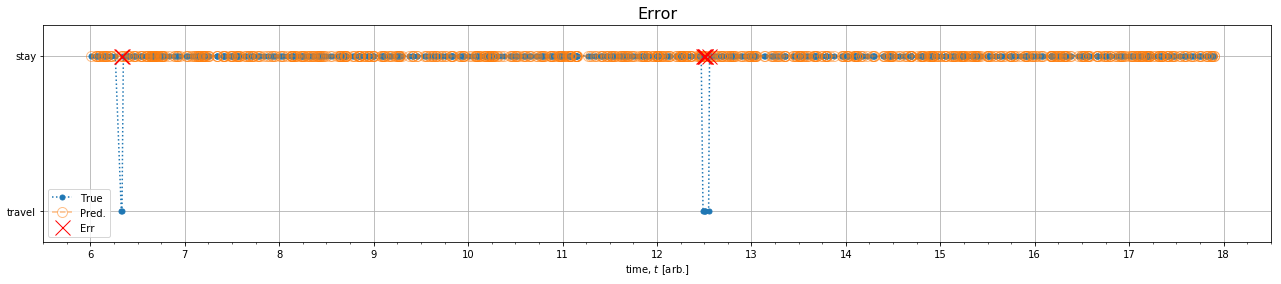

In [42]:
fig, ax = plt.subplots(1,1,figsize=(22,4))

plt.plot(t_arr, true_labels, '.:', markersize=10, label='True')
plt.plot(t_arr, pred_labels, 'o--', markerfacecolor="None", markersize=10, label='Pred.', alpha=0.5)
plt.plot(t_arr, err__labels, 'rx', markersize=15, label='Err')
plt.ylim(-0.2,1.2)
plt.xlim(5.5,18.5)

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

plt.xlabel(r'time, $t$ [arb.]')

ax.set_yticks([0,1])
ax.set_yticklabels(['travel', 'stay'])
ax.set_title('Error', fontsize=16)

plt.legend()
plt.grid();

In [43]:
for clusters in all_clusters:
    
    pred_labels = get_pred_labels(clusters, t_arr.shape)
    
    print(f"{get_err(true_labels,pred_labels):6.3}")

0.00814
0.00814
0.00814
0.00814
0.00814


In [44]:
pred_labels = get_pred_labels(all_clusters_res2[-1], t_arr.shape)
err__labels = abs(true_labels-pred_labels)
err__labels[err__labels == 0] = np.nan

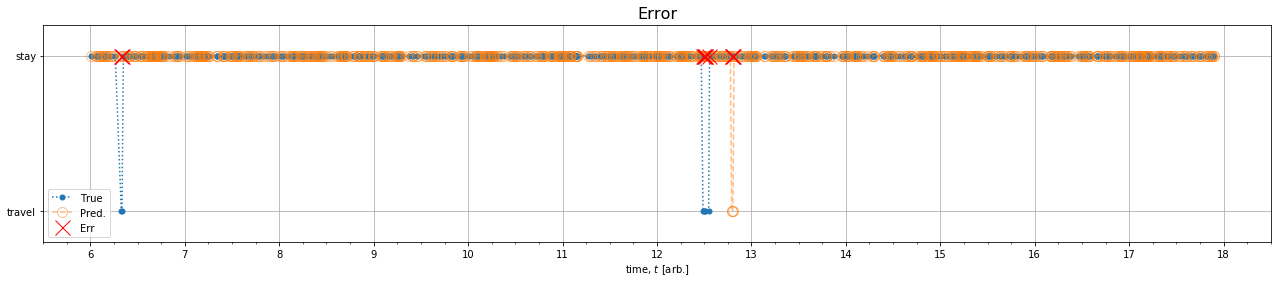

In [45]:
fig, ax = plt.subplots(1,1,figsize=(22,4))

plt.plot(t_arr, true_labels, '.:', markersize=10, label='True')
plt.plot(t_arr, pred_labels, 'o--', markerfacecolor="None", markersize=10, label='Pred.', alpha=0.5)
plt.plot(t_arr, err__labels, 'rx', markersize=15, label='Err')
plt.ylim(-0.2,1.2)
plt.xlim(5.5,18.5)

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

plt.xlabel(r'time, $t$ [arb.]')

ax.set_yticks([0,1])
ax.set_yticklabels(['travel', 'stay'])
ax.set_title('Error', fontsize=16)

plt.legend()
plt.grid();

In [46]:
for clusters in all_clusters_res2:
    
    pred_labels = get_pred_labels(clusters, t_arr.shape)
    
    print(f"{get_err(true_labels,pred_labels):6.3}")

0.0105
0.00814
0.0151
0.0116
0.0116


In [47]:
pred_labels = get_pred_labels(all_clusters_res3[-1], t_arr.shape)
err__labels = abs(true_labels-pred_labels)
err__labels[err__labels == 0] = np.nan

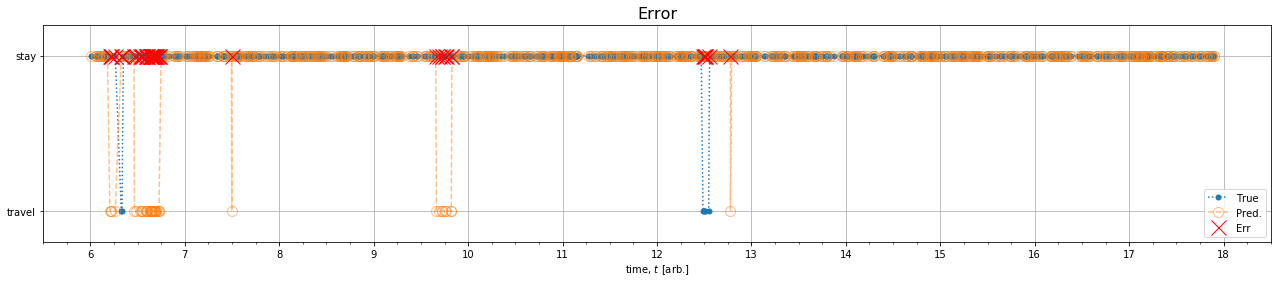

In [48]:
fig, ax = plt.subplots(1,1,figsize=(22,4))

plt.plot(t_arr, true_labels, '.:', markersize=10, label='True')
plt.plot(t_arr, pred_labels, 'o--', markerfacecolor="None", markersize=10, label='Pred.', alpha=0.5)
plt.plot(t_arr, err__labels, 'rx', markersize=15, label='Err')
plt.ylim(-0.2,1.2)
plt.xlim(5.5,18.5)

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

plt.xlabel(r'time, $t$ [arb.]')

ax.set_yticks([0,1])
ax.set_yticklabels(['travel', 'stay'])
ax.set_title('Error', fontsize=16)

plt.legend()
plt.grid();

In [49]:
for clusters in all_clusters_res3:
    
    pred_labels = get_pred_labels(clusters, t_arr.shape)
    
    print(f"{get_err(true_labels,pred_labels):6.3}")

0.0512
0.00814
0.0349
 0.014
0.0593


**Notes**
The total errors of each classification stage seem to indicate that they initially do better but then get worse as the progression continues. 

#### Segment-based error

In all cases, the total err increases with the resolution; however, segment-based avg. and weighted avg. errors decrease: from $0.7$ to $0.3$ to $0.2$.

In [50]:
get_segments_errs(t_arr, segments, all_clusters[-1], True);

Predicted 1 of 3 true clusters

Cluster   0: [   0, 859]; dur: 11.891, (frac.  1.000)
             [   0,  18], overlap
             [  21, 473], overlap
             [ 479, 859], overlap

	Overlap with 3 true cluster(s):
          0; [   0,  18]; err.:  0.978; w-avg. err.:  0.978
          1; [  21, 473]; err.:  0.473; w-avg. err.:  0.473
          2; [ 479, 859]; err.:  0.557; w-avg. err.:  0.557

Stats: 
    max. err.:  0.669
    avg. err.:  0.669
  w-avg. err.:  0.669
    tot. err.:  0.008


In [51]:
get_segments_errs(t_arr, segments, all_clusters_res2[-1], True);

Predicted 2 of 3 true clusters

Cluster   0: [   0, 496]; dur:  6.766, (frac.  0.571)
             [   0,  18], overlap
             [  21, 473], overlap
             [ 479, 859], overlap

	Overlap with 3 true cluster(s):
          0; [   0,  18]; err.:  0.556; w-avg. err.:  0.317
          1; [  21, 473]; err.:  0.051; w-avg. err.:  0.029
          2; [ 479, 859]; err.:  0.979; w-avg. err.:  0.559

Cluster   1: [ 500, 859]; dur:  5.086, (frac.  0.429)
             [   0,  18], none
             [  21, 473], none
             [ 479, 859], overlap

	Overlap with 1 true cluster(s):
          2; [ 479, 859]; err.:  0.024; w-avg. err.:  0.010

Stats: 
    max. err.:  0.529
    avg. err.:  0.277
  w-avg. err.:  0.312
    tot. err.:  0.012


In [52]:
get_segments_errs(t_arr, segments, all_clusters_res3[-1], True);

Predicted 7 of 3 true clusters

Cluster   0: [   0,  14]; dur:  0.169, (frac.  0.015)
             [   0,  18], overlap
             [  21, 473], none
             [ 479, 859], none

	Overlap with 1 true cluster(s):
          0; [   0,  18]; err.:  0.005; w-avg. err.:  0.000

Cluster   1: [  19,  28]; dur:  0.135, (frac.  0.012)
             [   0,  18], none
             [  21, 473], overlap
             [ 479, 859], none

	Overlap with 1 true cluster(s):
          1; [  21, 473]; err.:  0.520; w-avg. err.:  0.006

Cluster   2: [  59, 108]; dur:  0.746, (frac.  0.066)
             [   0,  18], none
             [  21, 473], overlap
             [ 479, 859], none

	Overlap with 1 true cluster(s):
          1; [  21, 473]; err.:  0.469; w-avg. err.:  0.031

Cluster   3: [ 110, 259]; dur:  2.160, (frac.  0.192)
             [   0,  18], none
             [  21, 473], overlap
             [ 479, 859], none

	Overlap with 1 true cluster(s):
          1; [  21, 473]; err.:  0.352; w-avg. er

---

# Appendix

## Example 2 plots

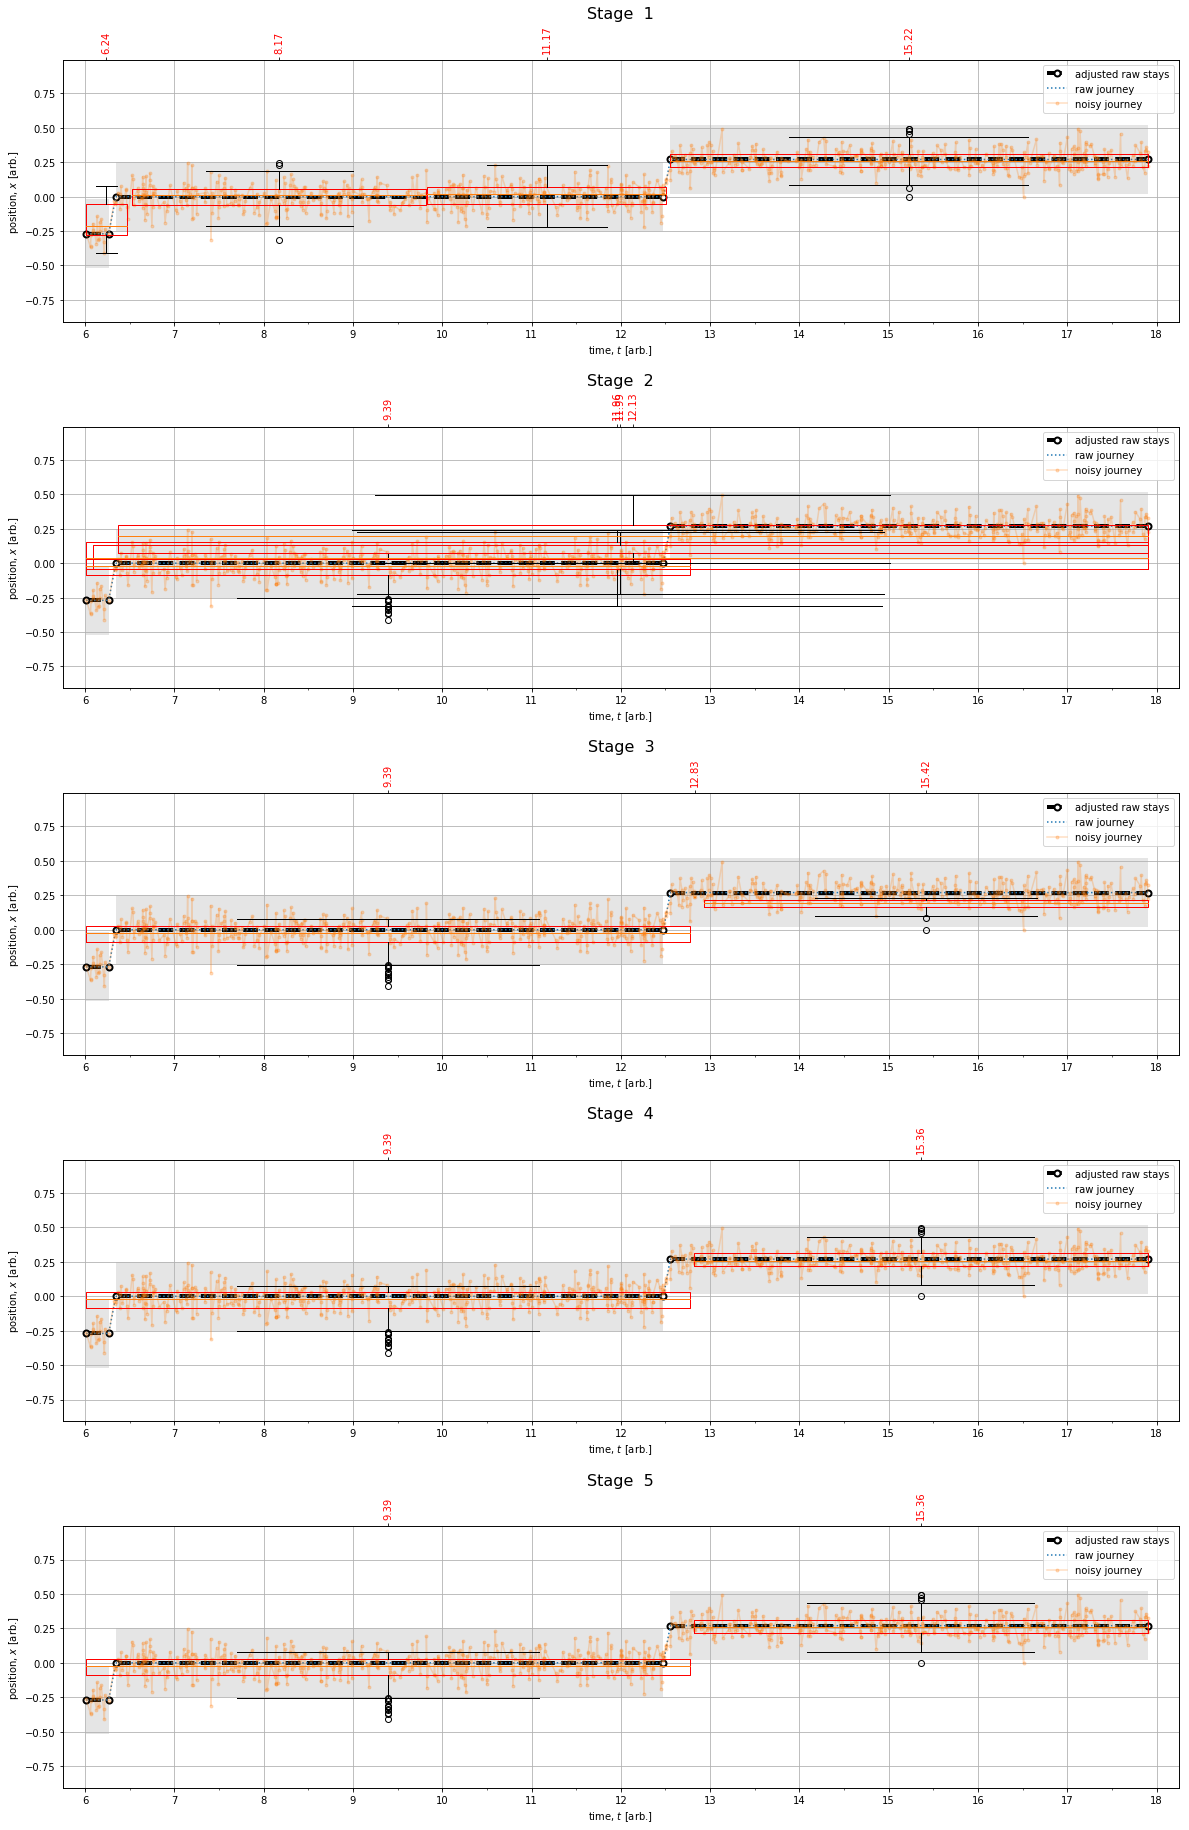

In [53]:
len_all_clusts = len(all_clusters_res2)
fig, axs = plt.subplots(len_all_clusts,1,figsize=[20,len_all_clusts*6])
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.4)
ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

axs =axs.flatten()

for i in range(len_all_clusts):
    try:
        ax = axs[i]
        add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
        #ax.set_xlim(0.7,23.3)
        ax.set_xlim([5.75,18.25]);
        add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
        add_plot_cluster_boxplots(t_arr, x_arr, all_clusters_res2[i], dist_thresh, ax)
        ax.set_ylim(ylim);
        ax.set_title(f"Stage{(i+1):3d}", fontsize=16);
    except:
        print(f"File {ii}, plotting stage {i} failed")
        pass

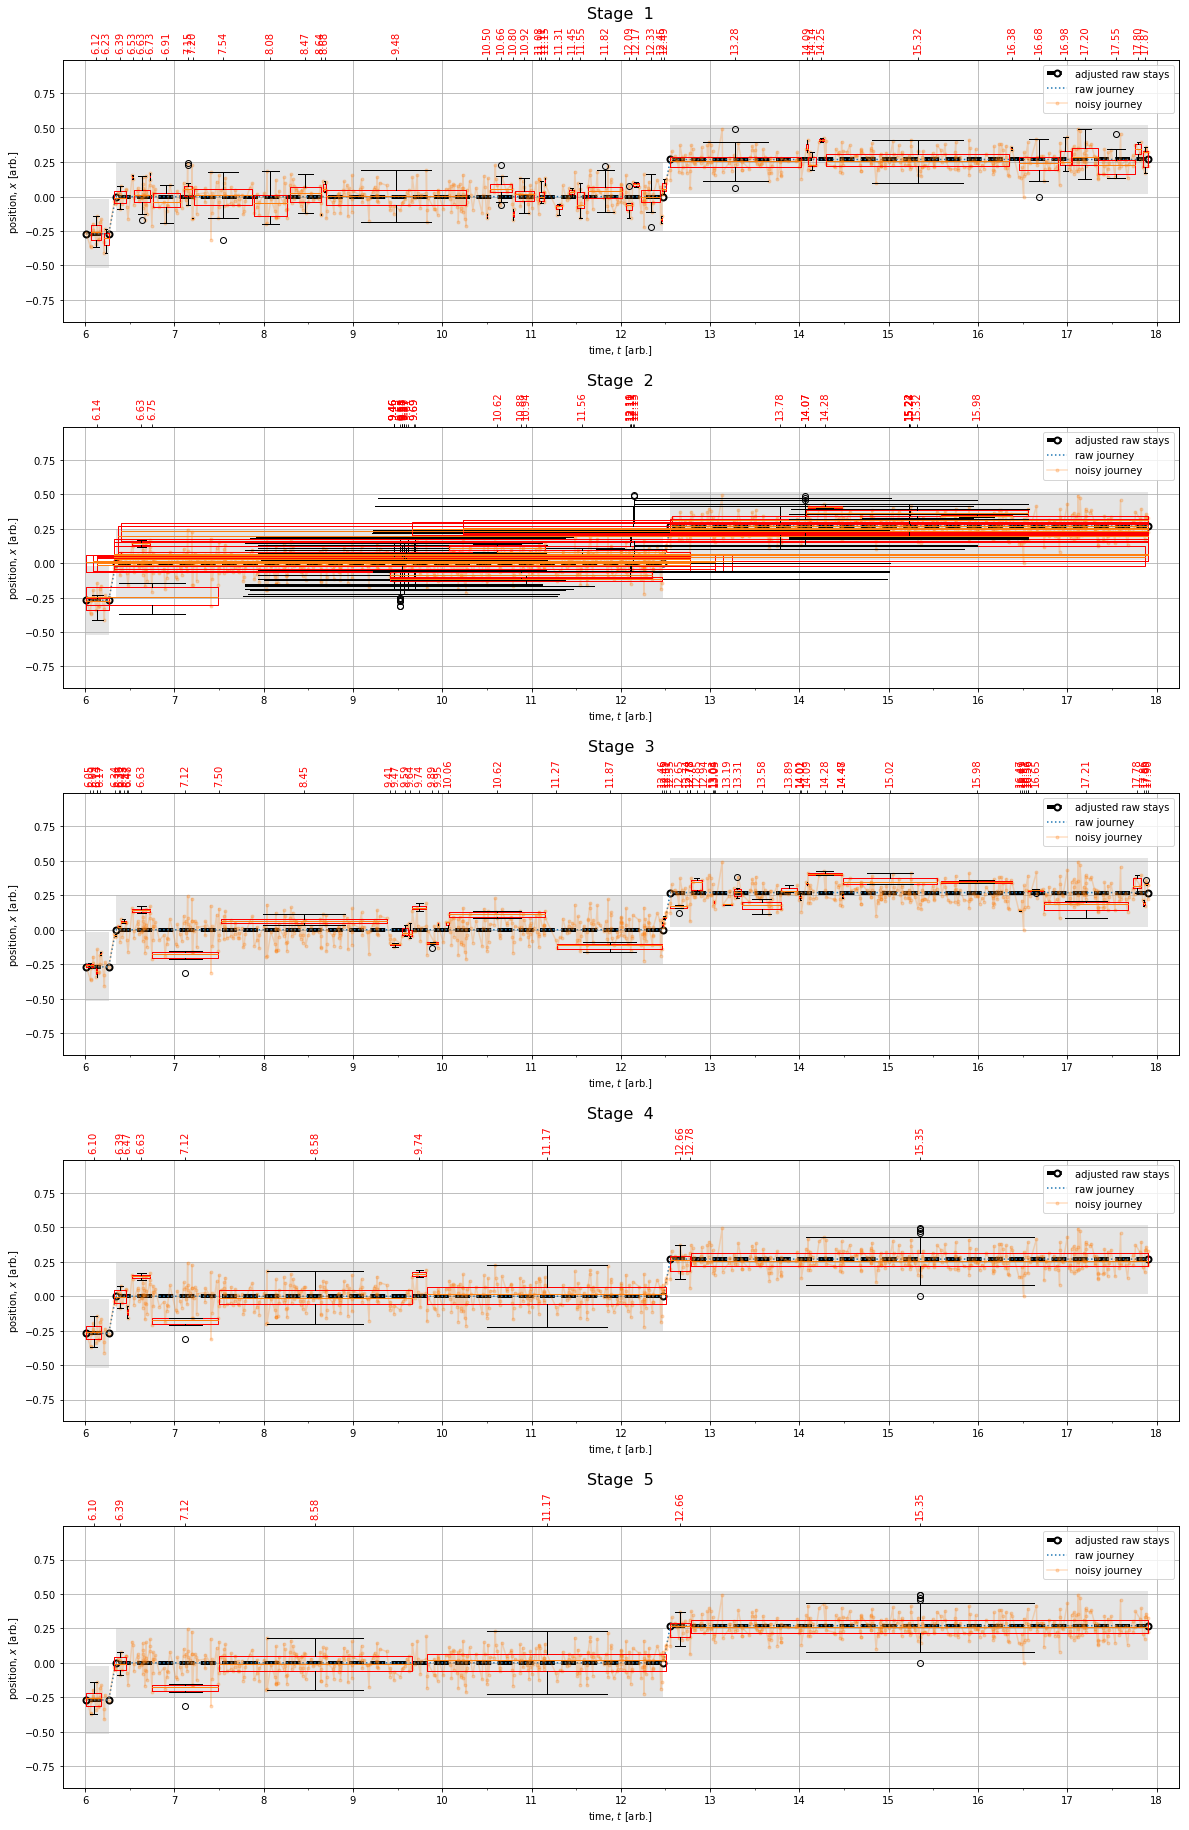

In [54]:
len_all_clusts = len(all_clusters_res3)
fig, axs = plt.subplots(len_all_clusts,1,figsize=[20,len_all_clusts*6])
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.4)
ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

axs =axs.flatten()

for i in range(len_all_clusts):
    try:
        ax = axs[i]
        add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
        #ax.set_xlim(0.7,23.3)
        ax.set_xlim([5.75,18.25]);
        add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
        add_plot_cluster_boxplots(t_arr, x_arr, all_clusters_res3[i], dist_thresh, ax)
        ax.set_ylim(ylim);
        ax.set_title(f"Stage{(i+1):3d}", fontsize=16);
    except:
        print(f"File {ii}, plotting stage {i} failed")
        pass